# PersonAttributes Classifier - training a multi-task neural network to detect attributes like age, gender, ..., emotion 

The goal of this challenge is to detect a person's `gender, age, weight, carryingbag, footwear, emotion, bodypose` as well as the `imagequality` all from a single image. Any neural network architecture is allowed. But the **training has to be done from scratch, that means no pre-trained weights, and no transfer learning.**<br>
To complete this successfully we will require a convolutional neural network with multiple outputs, each output catering to a prediction.<br> For this challenge I ended up using a **Densenet121** architecture, but any modern parallel network with skip connections should provide good results.<br> The training is done using **Keras**. I also tried **one-cycle policy and cyclic LR in tensorflow**, but found the keras solution simple and effective. <br>
Before we take a look at the proposed network architecture let's take a look at the dataset we are dealing with.

You can download the dataset from [person-data-gdrive](https://drive.google.com/file/d/1Abe336Tzvi8BC6bVGTN3unlAtj1XdiTT/view) for experimentation.<br> Also find the [person-classifier-github-link](https://github.com/baronrogers5/person-classifier) which contains the notebook that can directly be run on [google-colab](https://colab.research.google.com/).<br>
If you are running the notebook on colab, just make sure to download the data and put it in your google drive's `My Drive` as `hvc_data.zip`. <br>
All the required files visualized below are present in the `hvc_data.zip` file.

## Visualizing the data

Each image is labelled according to the dataframe given below:

![person-df](https://raw.githubusercontent.com/baronrogers5/person-classifier/master/images/df_head.png)

Some examples of the images we have.

![raw-data](https://raw.githubusercontent.com/baronrogers5/person-classifier/master/images/display_images.png)

Let's see all possible predictions for each category

```
gender
--------------------
['male' 'female']

imagequality
--------------------
['Average' 'Good' 'Bad']

age
--------------------
['35-45' '45-55' '25-35' '15-25' '55+']

weight
--------------------
['normal-healthy' 'over-weight' 'slightly-overweight' 'underweight']

carryingbag
--------------------
['Grocery/Home/Plastic Bag' 'None' 'Daily/Office/Work Bag']

footwear
--------------------
['Normal' 'CantSee' 'Fancy']

emotion
--------------------
['Neutral' 'Angry/Serious' 'Happy' 'Sad']

bodypose
--------------------
['Front-Frontish' 'Side' 'Back']
```

## Viewing the network's head



As promised let's have a look at the head (where the output's arrive) of the network, so that we can understand the code better.<br> Some connections are not-visible to post a clearer image. Find the full network image [here](https://github.com/baronrogers5/person-classifier/blob/master/images/model.png).<br><br>

![model-head](https://raw.githubusercontent.com/baronrogers5/person-classifier/master/images/model_head.png)

Now that we have an idea about the problem at hand, let's start with the actual steps required to train an awesome classifier from scratch.

- Data Preprocessing -
    - Converting to one-hot encoded.
    - Normalizing using the mean and std-dev.
    - Data Augmentation([cutout](https://github.com/yu4u/cutout-random-erasing))
    - Building a keras Sequence to feed to the training loop.
- Designing the architecture -
    - Choosing a backbone
    - Constructing the tower.
    - Constructing heads [final predictions] for each class.
- Defining the training callbacks
- Actual training.

## Data PreProcessing

### Converting to one-hot encoded



Neural networks expect the prediction labels to be one-hot encoded. So that the predicted probabilities [equal to the number of classes] can be directly matched against the correct labels.

Hence, we need to convert all our prediction labels to one-hot encoded *with a prefix*, so that it becomes easier to identify them.

```python
one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

df.shape
```
##### (13573, 9)


The one-hot encoded data

In [108]:
one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


### Normalizing using the mean and std-*dev*

```python
images = np.array([cv2.resize(io.imread(p), (200, 200)) for p in df.iloc[:, -1]])
mean = []
std = []
for i in range(images.shape[-1]):
    pixels = images[:, :, :, i].ravel()
    mean.append(np.mean(pixels))
    std.append(np.std(pixels))

print(mean, std)

# Output
([46.56585295255286, 41.46895223605688, 41.246545649451114],
 [69.21208428987939, 63.936488294726296, 63.29494237674264])
```

The original size of the images were 200x200, and they were resized while sharing the dataset, because the default training and inference were done against vgg16, which requires a (224x224) input.

Since, we will be using a [densenet](https://towardsdatascience.com/review-densenet-image-classification-b6631a8ef803) as our architecture. We don't need the extra computation and hence we resize the images to (200x200).

This resizing is done in the PersonDataGenerator class.

Let's create the keras Sequence which can be called to give a sequence of batches when called by `fit_generator`

### Building a keras Sequence to feed to the training loop



Let's build the sequence class which will give batches of data as a generator, shuffle it and apply data augmentations if specified. 

```python
class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    def __init__(self, df, batch_size=32, image_size=200, shuffle=True, augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.image_size = image_size
        self.normalize_image = lambda x: (x - mean) / std
        self.on_epoch_end()
        

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        
        # resizing the image to (self.image_size, self.image_size)
        image = np.stack([self.normalize_image(cv2.resize(cv2.imread(item["image_path"]), 
                                            (self.image_size, self.image_size))) for _, item in items.iterrows()])

        if self.augmentation is not None:
            # This is required for featurewise-center and featurewise-stdnorm
            # self.augmentation.fit(image)
            image = self.augmentation.flow(image, shuffle=False).next()

        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
```

Let's quickly call the PersonDataGenerator class to create the train and test generators.

```python
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32, image_size=200, augmentation=ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=get_random_eraser(v_h=1, s_l=0.01, s_h=0.2, r_1=0.1, r_2=1)
))

valid_gen = PersonDataGenerator(val_df, batch_size=32, image_size=200, shuffle=False)

# get number of output units from data
images, targets = next(iter(train_gen))
# num_units actually tells the number of one-hot encoded values / choices for a category
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}

print(num_units)

# output

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}
```

## Designing the architecture 

### Choosing a backbone

We are not using pre-trained weights and starting from scratch as that was one of the requirements of this exercise.
We take a **DenseNet121** backbone, without the head. This was chosen over **Resnet50**, but that should also provide comparable results.

Since this is a multi-task classification. The final model we are going for would be something like this:


```
inputs -> 
        densenet121 + GAP -> (
                            tower + gender_head,
                            tower + age_head,
                            tower + emotion_head, ...
                                                    ) -> outputs 

```
1. Choose an architecture as a backbone (here we are choosing densenet121, as it worked better than resnet50 in intial tests), do not include the head, as we would build our own.
2. Build towers for each class, the architecture of the towers would largely remain the same.
3. Build the respective heads which are the outputs for each class.
4. Construct the overall model, specifying the inputs and the outputs.  

Code for the backbone

```python
backbone = DenseNet121(
    include_top=False,
    input_shape=(200, 200, 3),
    weights= None
)

model = Model(inputs=backbone.input, outputs=backbone.output)
```

![backbone head](https://raw.githubusercontent.com/baronrogers5/person-classifier/master/images/backbone_head.png)

The final shape after relu is (6, 6, 1024). 

This is passed through GlobalAveragePooling (further referenced as GAP) to average each feature map across the channel dimension. This brings the tensor shape to a flat (None, 1024).

 I strongly believe this can be improved if instead of only using GAP, we also use GlobalMaxPooling and concatenate the outputs. That results in 2048 rank 1 tensor, which would have advantages of both mean and max results.

### Constructing the tower

The tower adds a batchnorm after GAP, to normalize the results after GAP and also a small amount of dropout, to improve resilience.<br> It is followed by a densely connected layer that reduces the nodes to 128, on which each head builds.

```python
def build_tower(in_layer):
    neck = BatchNormalization()(in_layer)
    neck = Dropout(0.1)(neck)
    neck = Dense(128, activation='relu')(neck)
    return neck
```



### Constructing the heads

The head is the final layer that produces outputs.<br> Let's take pose, there can be 3 possible outputs for it, namely **(front-frontish, back and side)**, so each possible output needs a final node which represents the probability of it's occurrence.<br> `num_units` contains the mapping of each name and the number of categories present. `build_head` builds the heads of each categroy assigning appropriate final nodes as per `num_units`.  

```
{
    'age': 5,
    'bag': 3,
    'emotion': 4,
    'footwear': 3,
    'gender': 2,
    'image_quality': 3,
    'pose': 3,
    'weight': 4
 }
 ```

 ```python
 def build_head(name, in_layer):
    return Dense(num_units[name], activation='softmax', name=f'{name}_output')(in_layer)
```

### Code to build the complete Model

```python
backbone = DenseNet121(
    include_top=False,
    input_shape=(200, 200, 3),
    weights=None,                     # No pre-trained weights, for imagenet weights, pass `imagenet` as arg. 
)

# 
neck = GlobalAveragePooling2D()(backbone.output)

def build_tower(in_layer):
    neck = BatchNormalization()(in_layer)
    neck = Dropout(0.1)(neck)
    neck = Dense(128, activation='relu')(neck)
    return neck

def build_head(name, in_layer):
    return Dense(num_units[name], activation='softmax', name=f'{name}_output')(in_layer)

#heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input,
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)
```

You can check out how the complete network looks [here](https://github.com/baronrogers5/person-classifier/blob/master/images/model.png)

## Defining the training callbacks


1. `ReduceLROnPlateau` -> To reduce learning_rate when the model val_loss does not improve by `min_delta` for some `patience` epochs
2. `ModelCheckpoint` -> To save the model weights, in specified directory.
3. `EarlyStopping` -> To stop training if `val_loss` does not improve by `min_delta` for `patience` epochs, restore the `best_weights` during training after stopping. 

```python
# reduce lr on plateau
reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=3,
    min_lr=1e-6,
    verbose=1,
    min_delta=1e-3
)

# save the model
save_dir = os.path.join(os.getcwd(), 'gdrive/My Drive/Person_MultiClass')
model_name = 'person_multiclass_model_densenet_200_normalized_frozen_reduce_dropout.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# checkpoint callback
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

# Early Stopping
early_stopping = EarlyStopping(
    patience=8,
    verbose=1,
    min_delta=1e-3,
    restore_best_weights=True
)
```

Let's compile the model before we start the actual training.


The model compilation step has been implemented as a function, so that it can be called from any cell, and on any model (backbone or partial models)

```python
def compile_model(model):
    model.compile(
        optimizer=Adam(lr=1e-3),
        loss = 'categorical_crossentropy',
        metrics=['accuracy']
    )
```

## Let the training begin

Initial rounds of training were done with a smaller image size of (100x100), so that the model gets to adjust it's initial weights. <br> This helps when data of size (200x200) is introduced, as it acts as completely new data for the model. And, we can do the fine-tuned training with the larger images.

The training was carried on in the following sequence:

1. (100x100) images with all layers trainable.
2. (100x100) images with backbone frozen, so that the final layers could be fine-tuned.
3. (100x100) images with all trainable layers but aggressive data augmentation with a `lr = 1e-4`.
4. (200x200) images with all trainable layers.
5. (200x200) images with backbone frozen.

All the training loops had `EarlyStopping` enabled, so the number of epochs ranged from 8-15 in each case, after which the training stopped and the next step was run.

For the purpose of brevity, I will not include all training steps here, but you can always check the [actual colab file](https://github.com/baronrogers5/person-classifier/blob/master/Person_using_DenseNet.ipynb), which has all the steps with logs.

If you wish to continue training, and wish to use my pre-trained weights, you can find them in the [github repo models folder](https://github.com/baronrogers5/person-classifier/tree/master/models).

```python
compile_model(model)

model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    verbose=1,
    callbacks=[reduce_lr_on_plateau, checkpoint, early_stopping]
)
```

## Results

```python
def show_results(model: keras.Model, show_loss=False):
    data = []
    results = model.evaluate_generator(valid_gen, verbose=1)
    for m, r in zip(model.metrics_names, results):
        if show_loss:
            data.append({'metric_name': m, 'accuracy': r})            
        
        elif 'acc' in m:
                data.append({'metric_name': m, 'accuracy': r})
    
    df = pd.DataFrame(data, columns=['metric_name', 'accuracy'])
    print(df)


compile_model(model)
model.load_weights('/content/gdrive/My Drive/Person_MultiClass/person_multiclass_model_densenet_200_normalized_frozen_augmented.h5')
show_results(model, show_loss=True)

# Output

63/63 [==============================] - 16s 249ms/step
                  metric_name  accuracy
0                        loss  6.113962
1          gender_output_loss  0.267376
2   image_quality_output_loss  0.883270
3             age_output_loss  1.261447
4          weight_output_loss  0.901494
5             bag_output_loss  0.746320
6        footwear_output_loss  0.760049
7            pose_output_loss  0.419371
8         emotion_output_loss  0.874636
9           gender_output_acc  0.888889
10   image_quality_output_acc  0.584821
11             age_output_acc  0.447421
12          weight_output_acc  0.652778
13             bag_output_acc  0.697917
14        footwear_output_acc  0.670635
15            pose_output_acc  0.857143
16         emotion_output_acc  0.704365
```


## Further experiments / Ways to improve the model  

There can be a lot of ways to improve the results that we achieved here. I will keep updating the actual [github repo](https://github.com/baronrogers5/person-classifier) with some of these recommendations down the line. If you liked the article or would like further updates, please `watch` the github repo or `star` it. It would motivate me to work on other similar articles. 

So without further ado, I'm listing some recommendations in no particular order. 

1. Better normalization and weight initialization.
2. Loss weights for each individual class.
3. Better image augmentation especially [imgaug](https://github.com/aleju/imgaug).

<center>
    <img src="https://raw.githubusercontent.com/aleju/imgaug-doc/master/readme_images/augmenter_videos/coarsedropout_p_0_2.gif" alt="coarse dropout" align="middle">
</center>

4. Try different architectures example Inceptionv4, EfficientNet, ResNext.
5. Loose the regularizations such as dropout.
6. Try One Cycle Policy and Cyclic Learning Rate, especially the implemenation by [fast.ai](https://www.fast.ai/).
7. Instead of only GAP use `concatenate(GAP, GMP)`, and build tower after that.

I hope to implement some of these and see the loss decrease and get better results, also if any of you implement and see some interesting results, would love to hear more about it.


## TRials

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


NameError: ignored

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [3]:
df = pd.read_csv('hvc_annotations.csv'); df.head()


,filename,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,images/Set1/5580_2 (3).jpg,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,images/Set1/4650_1 (4).jpg,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,images/Set1/44880_0.jpg,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,images/Set1/26130_2.jpg,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,images/Set1/IMG (4438).jpg,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [0]:
from PIL import Image

In [0]:
def plot_multi():
    df1 = df[:10]
    fig, ax = plt.subplots(2, 2, squeeze=False, figsize=(20, 12))
    count = 0
    for i in range(2):
        for j in range(2):
            ax[i][j].imshow(Image.open(df1['image_path'][count]))
            # ax.text(x, y, str(int(c)), ha='center', va='center',
            #         color=text_color)
            ax[i][j].text(310, 100, json.dumps(df.iloc[count, 1:-1].to_dict(), indent=2, separators=('\n', ': ')), ha='center', va='center', color='black')
            count += 1

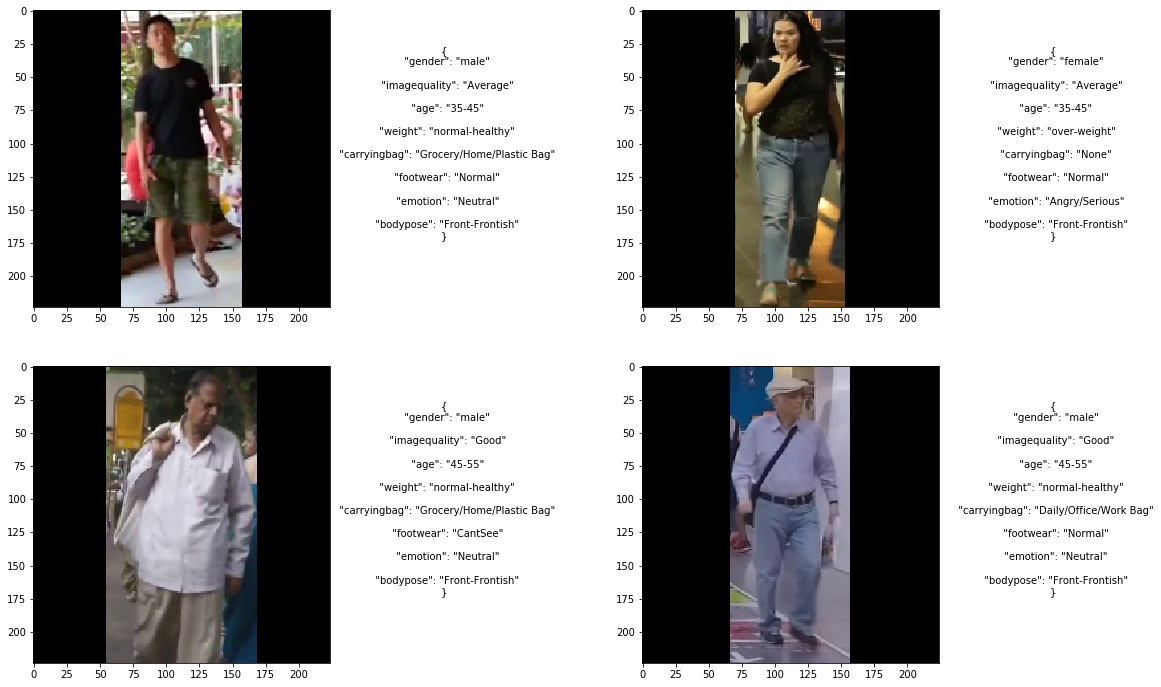

In [90]:
plot_multi()

In [107]:
one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

df.shape

(13573, 10)